C:\Users\bnsoh2\AppData\Local\Temp\ipykernel_17256\2343227852.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('plot_number').apply(lambda group: group.interpolate(method='pchip'))


                     VWC_06_mean  VWC_18_mean  VWC_30_mean  irrigation  \
TIMESTAMP                                                                
2023-07-20 01:00:00       23.800    18.766667       13.500         0.0   
2023-07-20 02:00:00       23.700    18.775000       13.525         0.0   
2023-07-20 03:00:00       23.775    18.725000       13.525         0.0   
2023-07-20 04:00:00       23.775    18.700000       13.500         0.0   
2023-07-20 05:00:00       23.750    18.750000       13.525         0.0   

                     daily_et  Rain_1m_Tot  precip_irrig  
TIMESTAMP                                                 
2023-07-20 01:00:00  0.924298          0.0           0.0  
2023-07-20 02:00:00  0.924298          0.0           0.0  
2023-07-20 03:00:00  0.924298          0.0           0.0  
2023-07-20 04:00:00  0.924298          0.0           0.0  
2023-07-20 05:00:00  0.924298          0.0           0.0  


C:\Users\bnsoh2\AppData\Local\Temp\ipykernel_17256\2343227852.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('plot_number').apply(lambda group: group.interpolate(method='pchip'))
Model is not converging.  Current: 10231.749351043818 is not greater than 27176.633467258886. Delta is -16944.884116215067


Training HMM with 2 components and diag covariance type
Target: VWC_06
Train MSE: 449.5824, Test MSE: 301.1807
Train R2: -146.4812, Test R2: -208.9988
Target: VWC_18
Train MSE: 267.7090, Test MSE: 315.1364
Train R2: -91.2097, Test R2: -44.5093
Target: VWC_30
Train MSE: 171.6558, Test MSE: 482.2990
Train R2: -155.1620, Test R2: -129.5858
Training HMM with 2 components and full covariance type
Target: VWC_06
Train MSE: 491.3946, Test MSE: 335.6475
Train R2: -160.1973, Test R2: -233.0308
Target: VWC_18
Train MSE: 300.0947, Test MSE: 350.1851
Train R2: -102.3646, Test R2: -49.5707
Target: VWC_30
Train MSE: 197.8251, Test MSE: 525.6077
Train R2: -178.9692, Test R2: -141.3119
Training HMM with 2 components and tied covariance type
Target: VWC_06
Train MSE: 482.7986, Test MSE: 328.3446
Train R2: -157.3774, Test R2: -227.9389
Target: VWC_18
Train MSE: 293.9493, Test MSE: 342.1744
Train R2: -100.2478, Test R2: -48.4138
Target: VWC_30
Train MSE: 192.7717, Test MSE: 516.6991
Train R2: -174.3719, 

Model is not converging.  Current: 10245.336485109647 is not greater than 27243.034978908498. Delta is -16997.698493798853


Target: VWC_06
Train MSE: 424.3892, Test MSE: 281.2302
Train R2: -138.2168, Test R2: -195.0882
Target: VWC_18
Train MSE: 247.4958, Test MSE: 296.1831
Train R2: -84.2474, Test R2: -41.7722
Target: VWC_30
Train MSE: 155.7923, Test MSE: 456.2595
Train R2: -140.7304, Test R2: -122.5354
Training HMM with 4 components and diag covariance type
Target: VWC_06
Train MSE: 407.1253, Test MSE: 266.7165
Train R2: -132.5535, Test R2: -184.9686
Target: VWC_18
Train MSE: 235.2783, Test MSE: 280.3156
Train R2: -80.0392, Test R2: -39.4807
Target: VWC_30
Train MSE: 145.8339, Test MSE: 438.4290
Train R2: -131.6708, Test R2: -117.7077
Training HMM with 4 components and full covariance type
Target: VWC_06
Train MSE: 447.9216, Test MSE: 299.9076
Train R2: -145.9363, Test R2: -208.1111
Target: VWC_18
Train MSE: 266.4561, Test MSE: 314.0238
Train R2: -90.7781, Test R2: -44.3486
Target: VWC_30
Train MSE: 170.6385, Test MSE: 480.6617
Train R2: -154.2365, Test R2: -129.1424
Training HMM with 4 components and tied

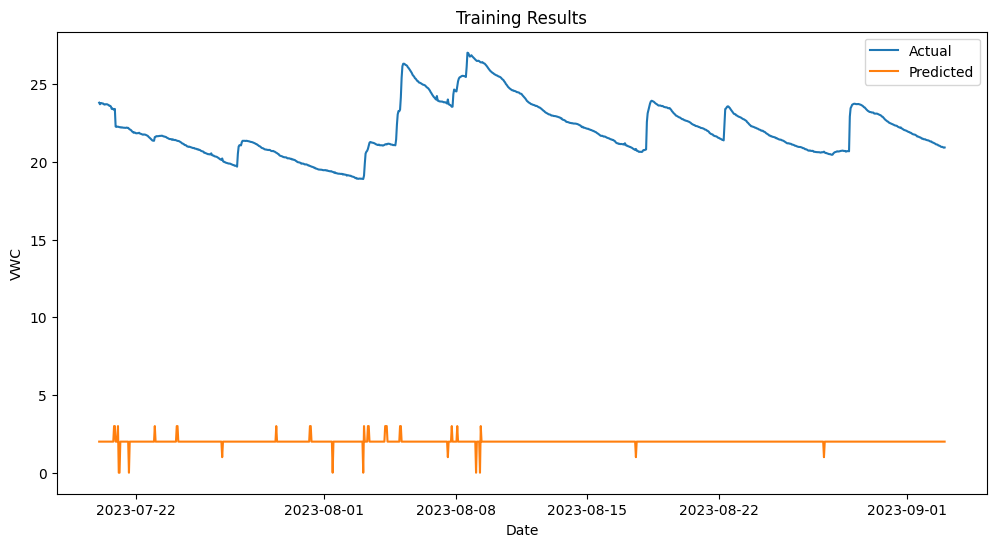

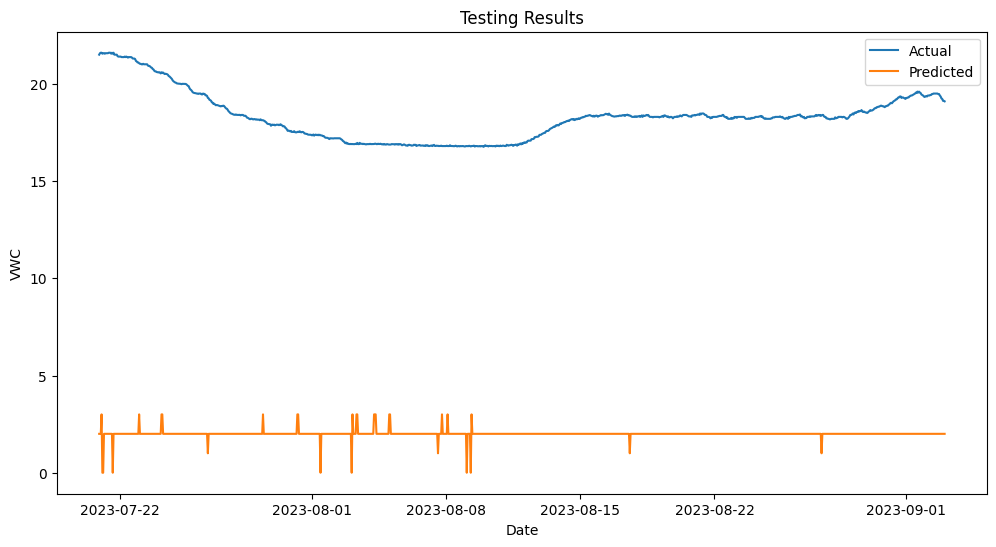

In [10]:
import numpy as np
import pandas as pd
import sqlite3
from hmmlearn import hmm
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt

def load_data(plot_numbers, start_date, end_date):
    conn = sqlite3.connect('processed_data.db')
    query = 'SELECT * from data_table'
    df = pd.read_sql_query(query, conn)
    conn.close()

    df = df[df['plot_number'].isin(plot_numbers)]
    df = df[['TIMESTAMP', 'plot_number', 'precip_irrig'] + target_columns + continuous_columns]
    df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'])
    df = df[(df['TIMESTAMP'] >= start_date) & (df['TIMESTAMP'] <= end_date)]
    df = df.drop_duplicates().set_index('TIMESTAMP').sort_index()
    
    # interpolate each plot number separately using pchip method
    df = df.groupby('plot_number').apply(lambda group: group.interpolate(method='pchip'))
    
    # remove the remaining rows with missing values
    df = df.dropna()
    
    # Group by timestamp and calculate the mean for each target and continuous column
    df_grouped = df.groupby(['TIMESTAMP']).agg({**{col: 'mean' for col in target_columns + continuous_columns}, 'precip_irrig': 'mean'})
    
    # Rename the columns to match the expected format
    df_grouped.columns = [f"{col}_mean" if col in target_columns else col for col in df_grouped.columns]
    
    return df_grouped

def train_hmm(data, n_components, covariance_type):
    model = hmm.GaussianHMM(n_components=n_components, covariance_type=covariance_type, n_iter=1000)
    model.fit(data)
    return model

def predict_hmm(model, data):
    predicted_values = model.predict(data)
    return predicted_values

def evaluate_model(model, X_train, X_test, y_train, y_test):
    y_pred_train = predict_hmm(model, X_train)
    y_pred_test = predict_hmm(model, X_test)

    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_test = mean_squared_error(y_test, y_pred_test)
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)

    return mse_train, mse_test, r2_train, r2_test

def plot_results(y_true, y_pred, title):
    plt.figure(figsize=(12, 6))
    plt.plot(y_true.index, y_true, label='Actual')
    plt.plot(y_true.index, y_pred, label='Predicted')
    plt.legend()
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('VWC')
    plt.show()

# Configuration
target_columns = ['VWC_06', 'VWC_18', 'VWC_30']
continuous_columns = ['irrigation', 'daily_et', 'Rain_1m_Tot']
train_plot_numbers = [2003, 2014, 2015]
test_plot_number = [2013]
start_date = '2023-07-20'
end_date = '2023-09-03'
n_components_list = [2, 3, 4]
covariance_type_list = ['diag', 'full', 'tied']

# Load and preprocess data
train_data = load_data(train_plot_numbers, start_date, end_date)
print(train_data.head())
test_data = load_data(test_plot_number, start_date, end_date)

# Prepare input features and target variables
X_train = train_data[continuous_columns].values
X_test = test_data[continuous_columns].values

# Evaluate models with different hyperparameters
best_model = None
best_mse_test = float('inf')

for n_components in n_components_list:
    for covariance_type in covariance_type_list:
        print(f"Training HMM with {n_components} components and {covariance_type} covariance type")
        
        model = train_hmm(X_train, n_components, covariance_type)
        
        for target_column in target_columns:
            y_train = train_data[f"{target_column}_mean"].values
            y_test = test_data[f"{target_column}_mean"].values
            
            mse_train, mse_test, r2_train, r2_test = evaluate_model(model, X_train, X_test, y_train, y_test)
            
            print(f"Target: {target_column}")
            print(f"Train MSE: {mse_train:.4f}, Test MSE: {mse_test:.4f}")
            print(f"Train R2: {r2_train:.4f}, Test R2: {r2_test:.4f}")
            
            if mse_test < best_mse_test:
                best_model = model
                best_mse_test = mse_test
                best_target_column = target_column

# Make predictions using the best model
y_pred_train = predict_hmm(best_model, X_train)
y_pred_test = predict_hmm(best_model, X_test)

# Plot the results for the best model
y_train_best = train_data[f"{best_target_column}_mean"].values
y_test_best = test_data[f"{best_target_column}_mean"].values

plot_results(pd.Series(y_train_best, index=train_data.index), y_pred_train, "Training Results")
plot_results(pd.Series(y_test_best, index=test_data.index), y_pred_test, "Testing Results")